<center>
<h1>In the name of Allah</h1>
</center>

**Name: Mohammad Taslimi**


**Student Number: 99101321**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm

# A. Load the pretrained Resnet on CIFAR10

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

batch_size = 128

########################## Problem 0 (0  points) ###############################
# todo: Define your data loaders for training and testing                      #
################################################################################

# your code goes here
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

################################ End ###########################################

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Files already downloaded and verified
Files already downloaded and verified


In [15]:
class resnet(nn.Module):
  def __init__(self, num_cls, T=1):
    super().__init__()
    self.conv = nn.Sequential(
        *list(resnet18(weights=None).children())[:-2])

    self.fc = nn.Linear(512, num_cls)
    self.temp = T

  def forward(self, x, T=None):
    if T is None:
      T = self.temp
    x = self.conv(x)
    x = torch.flatten(x, start_dim=1)
    logits = self.fc(x)
    output = torch.softmax(logits / T, dim=1)

    return logits, output

In [5]:
# Download trained weights of the Resnet18 model on CIFAR10 dataset
!gdown 1KU4jWAwZIq0TUujAsgimLxGWUvwIEfyB

Downloading...
From (original): https://drive.google.com/uc?id=1KU4jWAwZIq0TUujAsgimLxGWUvwIEfyB
From (redirected): https://drive.google.com/uc?id=1KU4jWAwZIq0TUujAsgimLxGWUvwIEfyB&confirm=t&uuid=66d71923-934c-4446-bbe4-3bf8a30297d6
To: /content/resnet18_cifar10_model_pretrained.pth
100% 44.8M/44.8M [00:00<00:00, 88.6MB/s]


In [16]:
# load trained Resnet18 model on CIFAR10 dataset
model = resnet(len(classes)).to(device)
model_name = "resnet18_cifar10_model_pretrained.pth"
model_PATH = "/content/" + model_name
state_dict = torch.load(model_PATH, map_location=device)
model.load_state_dict(state_dict)
model = model.to(device)

In [7]:
def standard_test(model, loader, device=device):
  correct = 0
  total = 0
  ########################## Problem 0 (0 points) ##############################
  # todo: Iterate over loader, compute the output and predicted                #
  # label, and update "correct" and "total" counters accordingly.              #
  ##############################################################################

  # your code goes here
  model.eval()
  with torch.no_grad():
      for data in loader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          _, outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  ################################ End #########################################
  print(f'Clean accuracy of the network on the 10000 test images: {100 * correct // total} %')


standard_test(model, testloader, device=device)

Clean accuracy of the network on the 10000 test images: 75 %


# B. PGD Attack

In [21]:
# Implement PGD attack

class LinfPGDAttack(object):

    def __init__(self, model, epsilon = 8/255, k = 2, alpha = 2/255):
        self.model = model
        self.epsilon = epsilon
        self.steps = k
        self.alpha = alpha

    def __call__(self, image, label):

        image = image.to(device)
        label = label.to(device)

        out, _ = self.model(image)
        _, pred = torch.max(out, 1)

        perturbed_image = image.clone()
        perturbed_image.to(device)

        if pred.item() == label.item():
            ########################## Problem 1 (8 points) ##############################
            # Implement a k step PGD attack of size alpha                                #
            # while always staying within epsilon distance from the initial point        #
            # Use cross entropy loss                                                     #
            ##############################################################################
            perturbed_image = perturbed_image + torch.rand_like(perturbed_image).to(device) * 2 * self.epsilon - self.epsilon
            perturbed_image = torch.clamp(perturbed_image, 0, 1)
            loss = nn.CrossEntropyLoss()

            for i in range(self.steps):
                perturbed_image = perturbed_image.detach().clone()
                perturbed_image.requires_grad = True

                out, _ = self.model(perturbed_image)
                attack_loss = loss(out, label)

                self.model.zero_grad()
                attack_loss.backward()

                perturbation = self.alpha * perturbed_image.grad.sign()
                perturbed_image = perturbed_image + perturbation
                perturbed_image = torch.clamp(perturbed_image, image - self.epsilon, image + self.epsilon)
                perturbed_image = torch.clamp(perturbed_image, 0, 1)
            ################################ End #########################################

        return perturbed_image

In [22]:
########################## Problem 2 (4 points) ##############################
# Evaluate PGD attack on the trained model with k=2,4,8                      #
##############################################################################

k_list = [2,4,8]

##############################################################################
testloader_adversarial_example = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)
standard_test(model, testloader, device=device)

for k in k_list:
    pgd_attack = LinfPGDAttack(model=model, k=k)
    success_rate = 0
    total_samples = 0

    for inputs, labels in testloader_adversarial_example:
        labels = labels.to(device)
        adversarial_inputs = pgd_attack(inputs, labels)

        _, predictions = model(adversarial_inputs)
        success_rate += (predictions.argmax(1) == labels).float().sum().item()
        total_samples += labels.size(0)

    success_rate /= total_samples
    print(f"Accuracy of adversarial examples generated using PGD attack with k={k}: {success_rate:.2f}")

################################ End #########################################

Clean accuracy of the network on the 10000 test images: 75 %
Accuracy of adversarial examples generated using PGD attack with k=2: 0.20
Accuracy of adversarial examples generated using PGD attack with k=4: 0.06
Accuracy of adversarial examples generated using PGD attack with k=8: 0.01


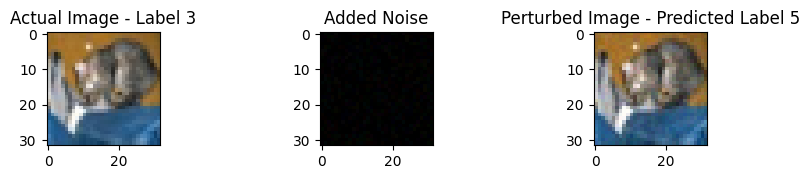

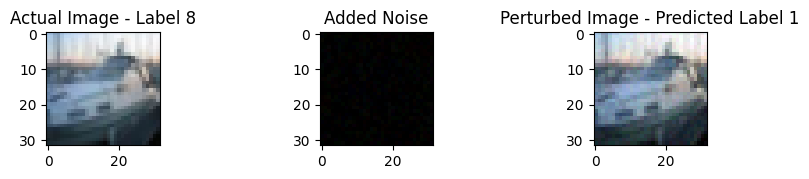

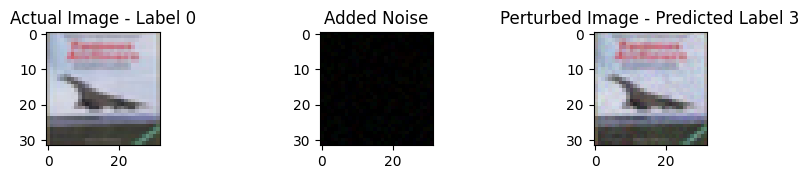

In [23]:
########################## Problem 3 (4 points) ##############################
# Choose 3 images from the test set that have been incorrectly classified    #
# and plot the actual image, the added noise, and the perturbed image        #
##############################################################################


##############################################################################

# Your code goes here

import matplotlib.pyplot as plt

incorrect_images = []
incorrect_labels = []
incorrect_preds = []
perturbed_images = []
model.eval()

pgd_attack = LinfPGDAttack(model=model, k=2)

for images, labels in testloader_adversarial_example:
    images = images.to(device)
    labels = labels.to(device)
    adversarial_inputs = pgd_attack(images, labels)
    _, outputs = model(adversarial_inputs)
    _, predicted = torch.max(outputs.data, 1)


    if predicted != labels:
      incorrect_images.append(images)
      incorrect_labels.append(labels)
      incorrect_preds.append(predicted)
      perturbed_images.append(adversarial_inputs)

    if len(incorrect_images) >= 3:
        break


for i in range(3):
    plt.figure(figsize=(10, 5))

    plt.subplot(3, 3, i*3+1)
    plt.imshow(incorrect_images[i].squeeze(dim=0).cpu().numpy().transpose((1, 2, 0)))
    plt.title(f'Actual Image - Label {incorrect_labels[i].item()}')

    plt.subplot(3, 3, i*3+2)
    noise = perturbed_images[i] - incorrect_images[i]
    plt.imshow(noise.squeeze(dim=0).cpu().detach().numpy().transpose((1, 2, 0)))
    plt.title('Added Noise')

    plt.subplot(3, 3, i*3+3)
    plt.imshow(perturbed_images[i].squeeze(dim=0).cpu().detach().numpy().transpose((1, 2, 0)))
    plt.title(f'Perturbed Image - Predicted Label {incorrect_preds[i].item()}')

plt.show()

################################ End #########################################

# C. FGSM Attack

In [26]:
########################## Problem 4 (2 points) ##############################
# Use your implementation from last HW for untargeted FGSM attack            #
##############################################################################

# Your code goes here


def FGSM (model, x, y, epsilon):
  """
  inputs:
    model: model to be attacked
    x: input image
    y: label
    epsilon: clipping threshold for FGSM

  outputs:
    x': the perturbed image
    delta: the added perturbation
    y': prediction of the model for the perturbed input
  """
  delta = None

  ######################
  # Your code goes here

  x.requires_grad = True

  _, outputs = model(x)
  loss = torch.nn.functional.cross_entropy(outputs, y)

  model.zero_grad()
  loss.backward()

  grad_x = x.grad.data
  delta = epsilon * grad_x.sign()
  x_prime = x + delta
  x_prime = torch.clamp(x_prime, 0, 1)


  return x_prime, delta, model(x_prime)




################################ End #########################################

In [27]:
########################### Problem 5 (2 points) #############################
# Evaluate untargeted FGSM attack on the trained model with epsilon = 8/255  #
##############################################################################

# Your code goes here


success_rate = 0
total_samples = 0
epsilon = 8/255
for inputs, labels in testloader_adversarial_example:
    labels = labels.to(device)
    inputs = inputs.to(device)
    adversarial_inputs, _, (_, predictions) = FGSM(model, inputs, labels, epsilon=epsilon)

    success_rate += (predictions.argmax(1) == labels).float().sum().item()
    total_samples += labels.size(0)

success_rate /= total_samples
print(f"Accuracy of adversarial examples generated using FGSM attack with elsilon={epsilon}: {success_rate:.2f}")

################################ End #########################################


Accuracy of adversarial examples generated using FGSM attack with elsilon=0.03137254901960784: 0.12


# D. Adversarial Training

In [ ]:
########################### Problem 6 (1 points) #############################
# Load a new resnet model for adversarial training                           #
##############################################################################

# Your code goes here
adv_model = resnet(len(classes)).to(device)

################################ End #########################################

In [ ]:
########################### Problem 6 (6 points) #############################
# Train the model on perturbed images from                                   #
# untargeted FGSM attack with epsilon = 8/255 on train dataset               #
# Also use the following setup for training the model                        #
##############################################################################

learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(adv_model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 100

##############################################################################

# Your code goes here
def adversarial_training(epoch, net, optimizer, trainloader, criterion):
    acc = None
    avg_loss = None

    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs, _, _ = FGSM (net, inputs, targets, epsilon)
        optimizer.zero_grad()
        _, outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    avg_loss = train_loss / (batch_idx + 1)
    acc = 100. * correct / total
    print(f'Train Loss: {avg_loss} | Acc: {acc}% ({correct}/{total})')
    return avg_loss, acc


train_loss_list = []
train_acc_list = []
test_acc_list = []

for epoch in range(epochs):
    train_loss, train_acc = adversarial_training(epoch, adv_model, optimizer, trainloader, criterion)
    test_acc = standard_test(adv_model, testloader, device=device)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)



################################ End #########################################


Epoch: 0
Train Loss: 2.2312404536225303 | Acc: 20.732% (10366/50000)
Clean accuracy of the network on the 10000 test images: 30 %

Epoch: 1
Train Loss: 2.2151096531802126 | Acc: 22.544% (11272/50000)
Clean accuracy of the network on the 10000 test images: 34 %

Epoch: 2
Train Loss: 2.2011242071381005 | Acc: 23.98% (11990/50000)
Clean accuracy of the network on the 10000 test images: 35 %

Epoch: 3
Train Loss: 2.1900379285787985 | Acc: 25.12% (12560/50000)
Clean accuracy of the network on the 10000 test images: 36 %

Epoch: 4
Train Loss: 2.1816958003031934 | Acc: 26.028% (13014/50000)
Clean accuracy of the network on the 10000 test images: 38 %

Epoch: 5
Train Loss: 2.174307018899552 | Acc: 27.048% (13524/50000)
Clean accuracy of the network on the 10000 test images: 40 %

Epoch: 6
Train Loss: 2.165191930883071 | Acc: 27.852% (13926/50000)
Clean accuracy of the network on the 10000 test images: 40 %

Epoch: 7
Train Loss: 2.159554780291779 | Acc: 28.602% (14301/50000)
Clean accuracy of 

In [28]:
# torch.save(adv_model, 'model.pth')

adv_model = torch.load('model.pth')
adv_model = adv_model.to(device)
adv_model.eval()


resnet(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [29]:
########################### Problem 7 (2 points) #############################
# Evaluate the new model on the test dataset                                 #
##############################################################################

# Your code goes here
standard_test(adv_model, testloader, device=device)
################################ End #########################################

Clean accuracy of the network on the 10000 test images: 55 %


In [37]:
########################### Problem 8 (3 points) #############################
#  Run PGD attack on the adversarially trained model with k=2,4,8            #
##############################################################################

k_list = [2,4,8]

##############################################################################

# Your code goes here

for k in k_list:
    pgd_attack = LinfPGDAttack(model=adv_model, k=k)
    success_rate = 0
    total_samples = 0

    for inputs, labels in testloader_adversarial_example:
        labels = labels.to(device)
        adversarial_inputs = pgd_attack(inputs, labels)
        _, predictions = adv_model(adversarial_inputs)
        success_rate += (predictions.argmax(1) == labels).float().sum().item()
        total_samples += labels.size(0)

    success_rate /= total_samples
    print(f"Accuracy of adversarial examples generated using PGD attack with k={k}: {success_rate:.2f}")
################################ End #########################################

Accuracy of adversarial examples generated using PGD attack with k=2: 0.39
Accuracy of adversarial examples generated using PGD attack with k=4: 0.29
Accuracy of adversarial examples generated using PGD attack with k=8: 0.21


In [35]:
########################### Problem 9 (1 points) #############################
# Run FGSM attack on the adversarially trained model with epsilon = 8/255    #
##############################################################################


# Your code goes here
success_rate = 0
total_samples = 0
epsilon = 8/255
for inputs, labels in testloader:
    labels = labels.to(device)
    inputs = inputs.to(device)
    adversarial_inputs, _, (_, predictions) = FGSM(adv_model, inputs, labels, epsilon=epsilon)

    success_rate += (predictions.argmax(1) == labels).float().sum().item()
    total_samples += labels.size(0)

success_rate /= total_samples
print(f"Accuracy of adversarial examples generated using FGSM attack with elsilon={epsilon}: {success_rate:.2f}")

################################ End #########################################

Accuracy of adversarial examples generated using FGSM attack with elsilon=0.03137254901960784: 0.27


# E. Analyze Results (5 points)

- Analyze the results for the 3 above cells

**Your Answer:**


In the course, two types of adversarial training were explained. One of them uses both adversarial examples and clean examples to train the model, while the other only uses adversarial examples. I used the latter approach to adversarially train my model. The approach is as follows:

In each epoch and for each batch, we find adversarial examples using the FGSM attack, and then we define a cross-entropy loss on these adversarial examples.

In the above approach, the adversarial examples are determined based on the current version of the model. As a result, the training data changes during training, and in each epoch, the model encounters different training data. Consequently, the clean accuracy is lower than that of normal training, but if we train for more epochs, we can increase the accuracy.

The clean accuracy is 55%. The accuracy of PGD attack is 39%, 29% and 21% for 2, 4, 8 steps recpectively and the accuracy of FGSM attack is 27%. As we can see from the results, the model is more robust to adversarial examples generated using the FGSM and PGD attacks. The accuracy has increased by an average of 18% compared to the standard model.

# F. Built-In Libraries

Use the following library and run FGSM and PGD attack for CIFAR10 test dataset on the given model and compare the results with your own results


https://adversarial-attacks-pytorch.readthedocs.io/en/latest/index.html

In [ ]:
!pip install torchattacks

In [22]:
########################### Problem 10 (12 points) #############################
# Run FGSM attack (using library) on the pretrained model for the test dataset #
# Run PGD attack (using library) on the pretrained model for the test dataset  #
################################################################################

## The resnet class is modified (it doens't return logits anymore) in order to be used for the built-in function.
class resnet(nn.Module):
  def __init__(self, num_cls, T=1):
    super().__init__()
    self.conv = nn.Sequential(
        *list(resnet18(weights=None).children())[:-2])

    self.fc = nn.Linear(512, num_cls)
    self.temp = T

  def forward(self, x, T=None):
    if T is None:
      T = self.temp
    x = self.conv(x)
    x = torch.flatten(x, start_dim=1)
    logits = self.fc(x)
    output = torch.softmax(logits / T, dim=1)

    return output
# load trained Resnet18 model on CIFAR10 dataset
model = resnet(len(classes)).to(device)
model_name = "resnet18_cifar10_model_pretrained.pth"
model_PATH = "/content/" + model_name
state_dict = torch.load(model_PATH, map_location=device)
model.load_state_dict(state_dict)
model = model.to(device)


import torchattacks

epsilon = 8/255
# Your code goes here


##### FGSM Attack  ######################
success_rate = 0
total_samples = 0
for inputs, labels in testloader:
    labels = labels.to(device)
    inputs = inputs.to(device)
    attack = torchattacks.FGSM(model, eps=epsilon)
    adv_images = attack(inputs, labels)

    predictions = model(adv_images)
    success_rate += (predictions.argmax(1) == labels).float().sum().item()
    total_samples += labels.size(0)

success_rate /= total_samples
print(f"Accuracy of adversarial examples generated using FGSM attack with elsilon={epsilon}: {success_rate:.2f}")




####### PGD Attack ########################



k_list = [2,4,8]

for k in k_list:
    success_rate = 0
    total_samples = 0

    for inputs, labels in testloader:
        labels = labels.to(device)
        inputs = inputs.to(device)

        attack = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=k, random_start=True)
        adv_images = attack(inputs, labels)

        # Evaluate the model on the adversarial inputs
        predictions = model(adv_images)
        success_rate += (predictions.argmax(1) == labels).float().sum().item()
        total_samples += labels.size(0)

    success_rate /= total_samples
    print(f"Accuracy of adversarial examples generated using PGD attack with k={k}: {success_rate:.2f}")




################################ End #########################################

Accuracy of adversarial examples generated using FGSM attack with elsilon=0.03137254901960784: 0.12
Accuracy of adversarial examples generated using PGD attack with k=2: 0.21
Accuracy of adversarial examples generated using PGD attack with k=4: 0.06
Accuracy of adversarial examples generated using PGD attack with k=8: 0.02


The result is the same as mine.